In [1]:
!pip install opensmile gdown --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 996.0/996.0 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.9/150.9 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.4/138.4 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.8/324.8 kB 32.5 MB/s eta 0:00:00


### Accessing Dataset

In [2]:
import os
import tarfile

# download tarball
!gdown 1p4ZQOwbHkD2RAvq2K5ekY5gcMi24XLnS

tarball_filename = "ADReSSo21-diagnosis-train.tar"

# extract all contents into the current working directory
with tarfile.open(tarball_filename, 'r:*') as tar:
    tar.extractall(path="./")

# clean up
os.remove(tarball_filename)

Downloading...
From (original): https://drive.google.com/uc?id=1p4ZQOwbHkD2RAvq2K5ekY5gcMi24XLnS
From (redirected): https://drive.google.com/uc?id=1p4ZQOwbHkD2RAvq2K5ekY5gcMi24XLnS&confirm=t&uuid=3e2ea0d2-f711-46cc-ae9c-4e87feb29458
To: /content/ADReSSo21-diagnosis-train.tar
100% 1.75G/1.75G [00:27<00:00, 63.9MB/s]


### Helper Functions

In [3]:
# disable HF & librosa progress/warnings
import os
os.environ["HF_HUB_DISABLE_PROGRESS_BARS"] = "1"
from transformers import logging
logging.disable_progress_bar()
logging.set_verbosity_error()

# unique library imports
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import librosa
import librosa.display
from IPython.display import Audio, display
import pandas as pd
import numpy as np
import soundfile as sf
import tempfile
import opensmile
import concurrent.futures
import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.base import clone
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
from tabulate import tabulate
from pathlib import Path
import torch
from transformers import Wav2Vec2Processor, Wav2Vec2Model
import re


import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.base import clone
from tabulate import tabulate
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from scipy.stats import skew



import os
import tempfile
from pathlib import Path
import numpy as np
import pandas as pd
import soundfile as sf
import opensmile



# define the base dataset directory and build related paths
dataset_dir = Path('ADReSSo21/diagnosis/train')
paths = {
    'audio': dataset_dir / 'audio',
    'audio_ad': dataset_dir / 'audio' / 'ad',
    'audio_cn': dataset_dir / 'audio' / 'cn',
    'segmentation': dataset_dir / 'segmentation',
    'segmentation_ad': dataset_dir / 'segmentation' / 'ad',
    'segmentation_cn': dataset_dir / 'segmentation' / 'cn'
}

def count_files(directory):
    """return the number of files in the specified directory."""
    return len([f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))])

def plot_waveform_data(waveform, sr, title="Waveform"):
    """plot the given waveform with its sampling rate."""
    plt.figure(figsize=(12, 4))
    librosa.display.waveshow(waveform, sr=sr)
    plt.title(title)
    plt.xlabel("time (s)")
    plt.ylabel("amplitude")
    plt.show()

def plot_waveform(file_path=None, folder=paths['audio_ad']):
    """
    load an audio file (default: first .wav in folder) and plot its waveform.
    """
    if file_path is None:
        wav_files = list(folder.glob("*.wav"))
        if not wav_files:
            print(f"no .wav files found in {folder}")
            return
        file_path = wav_files[0]
    else:
        file_path = Path(file_path)

    waveform, sr = librosa.load(str(file_path), sr=None)
    print("original waveform shape:", waveform.shape)
    print("sampling rate:", sr)
    print("duration (seconds):", len(waveform) / sr, "\n")

def load_audio_file(file_path: Path):
    """load and return the audio waveform and sample rate using soundfile."""
    return sf.read(file_path)

def load_segmentation(seg_file: Path):
    """load and return the segmentation csv as a dataframe."""
    return pd.read_csv(seg_file)

def extract_patient_segments(audio: np.ndarray, sr: int, seg_df: pd.DataFrame, speaker: str = "PAR"):
    """
    extract patient segments (where speaker==speaker) from the audio.
    returns:
      - patient_mask: array with patient segments (nan elsewhere).
      - concatenated: patient segments concatenated.
      - segments: list of (begin, end) sample index tuples.
    """
    patient_df = seg_df[seg_df['speaker'] == speaker]
    patient_mask = np.full_like(audio, np.nan)
    segments_list = []
    segments = []

    for _, row in patient_df.iterrows():
        begin_sample = int(float(row['begin']) * sr / 1000)
        end_sample = int(float(row['end']) * sr / 1000)
        patient_mask[begin_sample:end_sample] = audio[begin_sample:end_sample]
        segments_list.append(audio[begin_sample:end_sample])
        segments.append((begin_sample, end_sample))

    concatenated = np.concatenate(segments_list) if segments_list else np.array([])
    return patient_mask, concatenated, segments

def plot_overlay_waveform(audio: np.ndarray, sr: int, patient_mask: np.ndarray,
                          orig_color: str = "#0000FF", patient_color: str = "#00FF00"):
    """plot the original waveform and overlay the patient-only segments."""
    time_axis = np.linspace(0, len(audio) / sr, num=len(audio))
    plt.figure(figsize=(14, 4))
    plt.plot(time_axis, audio, color=orig_color, label="original")
    plt.plot(time_axis, patient_mask, color=patient_color, label="patient-only")
    plt.title("original audio with patient speech highlighted")
    plt.xlabel("time (s)")
    plt.ylabel("amplitude")
    plt.legend()
    plt.show()

def process_audio(audio_file: Path, seg_file: Path, plot: bool = False):
    """
    load audio and segmentation files, extract patient segments,
    optionally plot the overlay, and return processed data.
    """
    audio, sr = load_audio_file(audio_file)
    seg_df = load_segmentation(seg_file)
    patient_mask, concatenated, segments = extract_patient_segments(audio, sr, seg_df)
    if plot:
        plot_overlay_waveform(audio, sr, patient_mask)
    return audio, sr, patient_mask, concatenated, segments

def get_egemaps_features(patient_audio: np.ndarray, sr: int, audio_identifier: str) -> pd.DataFrame:
    """
    write the patient audio to a temporary wav file, extract the egemaps feature vector,
    and return a dataframe with the features and the audio identifier.

    parameters:
      patient_audio: numpy array containing the patient-only (concatenated) audio.
      sr: sampling rate of the audio.
      audio_identifier: string identifier for the audio (e.g., basename of the audio file).

    returns:
      dataframe with the extracted feature vector and an 'audio_file' column.
    """
    # write patient audio to a temporary wav file
    with tempfile.NamedTemporaryFile(suffix=".wav", delete=False) as tmp_file:
        temp_filename = tmp_file.name
    sf.write(temp_filename, patient_audio, sr)

    # initialize the opensmile smile object with egemaps settings
    smile = opensmile.Smile(
        feature_set=opensmile.FeatureSet.eGeMAPSv02,
        feature_level=opensmile.FeatureLevel.Functionals,
    )

    # extract egemaps features from the temporary wav file
    features_df = smile.process_file(temp_filename)

    # add identifier for the audio file to the dataframe
    features_df['audio_file'] = audio_identifier

    # reorder columns so that 'audio_file' is first
    cols = features_df.columns.tolist()
    cols = ['audio_file'] + [col for col in cols if col != 'audio_file']
    features_df = features_df[cols]

    # print the shape of the feature vector
    print(f"shape of the egemaps feature vector for {audio_identifier}: {features_df.shape}")

    return features_df

def process_and_extract_features(audio_file: Path, seg_folder: Path) -> pd.DataFrame:
    """
    process a single audio file: load the audio and its segmentation csv,
    extract the patient-only segments, compute the egemaps feature vector,
    and return the resulting dataframe.

    parameters:
      audio_file: path to the audio .wav file.
      seg_folder: path to the segmentation csv files (e.g., paths['segmentation_ad']).

    returns:
      dataframe containing the egemaps features with the file identifier,
      or None if no patient segments are found.
    """
    audio_basename = audio_file.stem
    seg_file = seg_folder / f"{audio_basename}.csv"
    _, sr, patient_mask, concatenated, _ = process_audio(audio_file, seg_file, plot=False)
    if concatenated.size == 0:
        print(f"no patient speech found in {audio_basename}. skipping feature extraction.")
        return None
    return get_egemaps_features(concatenated, sr, audio_basename)


def process_features_for_category(audio_folder: Path, seg_folder: Path, output_csv: str, file_limit: int = None):
    """
    process all audio files in a given audio folder with corresponding segmentation files,
    extract the eGeMAPS feature vector for patient-only segments, and save the results to a CSV.

    parameters:
      audio_folder: path to the folder containing audio (.wav) files.
      seg_folder: path to the folder containing segmentation CSV files.
      output_csv: name of the output CSV file.
      file_limit: optionally limit the number of files to process.
    """
    audio_files = list(audio_folder.glob("*.wav"))
    if file_limit:
        audio_files = audio_files[:file_limit]

    feature_dfs = []
    max_workers = os.cpu_count()
    print(f"processing {len(audio_files)} files from {audio_folder} using {max_workers} workers.")

    with concurrent.futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(process_and_extract_features, af, seg_folder) for af in audio_files]
        for future in concurrent.futures.as_completed(futures):
            result = future.result()
            if result is not None:
                feature_dfs.append(result)

    if feature_dfs:
        combined_df = pd.concat(feature_dfs, ignore_index=True)
        # create a sort key by extracting the numerical portion from the 'audio_file' string
        combined_df['sort_key'] = combined_df['audio_file'].str.extract('(\d+)', expand=False).astype(int)
        combined_df.sort_values(by='sort_key', inplace=True)
        combined_df.drop(columns=['sort_key'], inplace=True)
        combined_df.to_csv(output_csv, index=False)
        print(f"saved features to {output_csv}")
    else:
        print("no features were extracted from folder:", audio_folder)



def extract_eGeMAPS(audio_path):
    """
    Extract eGeMAPS features from an audio file using openSMILE.

    Parameters:
        audio_path: Path to the audio file.

    Returns:
        A 1D NumPy array of eGeMAPS features.
    """
    smile = opensmile.Smile(
        feature_set=opensmile.FeatureSet.eGeMAPSv02,
        feature_level=opensmile.FeatureLevel.Functionals,
    )
    features = smile.process_file(str(audio_path))
    return features.values.flatten()

def standardize(features, mean_val=None, std_val=None):
    """
    Standardize a feature vector (zero-mean, unit-variance).

    Parameters:
        features: NumPy array of features.
        mean_val: Optional pre-computed mean.
        std_val: Optional pre-computed standard deviation.

    Returns:
        A tuple of (standardized features, mean, std).
    """
    if mean_val is None:
        mean_val = np.mean(features, axis=0)
    if std_val is None:
        std_val = np.std(features, axis=0) + 1e-8  # prevent division by zero
    standardized = (features - mean_val) / std_val
    return standardized, mean_val, std_val

def add_gaussian_noise(features, noise_level=0.01):
    """
    Adds Gaussian noise to the feature vector.

    Parameters:
        features: NumPy array of features.
        noise_level: Standard deviation of the noise to be added.

    Returns:
        Features with added Gaussian noise.
    """
    noise = np.random.normal(0, noise_level, size=features.shape)
    return features + noise

def extract_patient_eGeMAPS(patient_audio: np.ndarray, sr: int) -> np.ndarray:
    """
    Extract eGeMAPS features from a patient audio NumPy array.
    The audio is temporarily saved as a WAV file and then processed using openSMILE.

    Parameters:
        patient_audio: NumPy array containing the patient-only (concatenated) audio.
        sr: Sampling rate.

    Returns:
        A flattened 1D NumPy array of the extracted eGeMAPS feature vector.
    """
    with tempfile.NamedTemporaryFile(suffix=".wav", delete=False) as tmp_file:
        temp_filename = tmp_file.name
    sf.write(temp_filename, patient_audio, sr)

    smile = opensmile.Smile(
        feature_set=opensmile.FeatureSet.eGeMAPSv02,
        feature_level=opensmile.FeatureLevel.Functionals,
    )
    features = smile.process_file(temp_filename)
    os.remove(temp_filename)
    return features.values.flatten()

def process_and_extract(file, seg_dir, label):
    """
    Process a single audio file to extract patient segments and then eGeMAPS features.

    Parameters:
        file: Path to the audio file.
        seg_dir: Directory containing the segmentation CSV for the file.
        label: Label for the audio (e.g., 1 for AD, 0 for CN).

    Returns:
        Tuple (features, label) if patient segments are found; otherwise (None, None).

    Note: This function assumes that a function named `process_audio` exists and returns
          a tuple (audio, sr, patient_mask, concatenated, segments).
    """
    # Construct segmentation file path based on the file stem
    seg_file = seg_dir / f"{file.stem}.csv"

    # process_audio must be implemented externally.
    audio, sr, patient_mask, concatenated, segments = process_audio(file, seg_file, plot=False)

    if concatenated.size > 0:
        feats = extract_patient_eGeMAPS(concatenated, sr)
        return feats, label
    else:
        print(f"No patient segments found in {file.stem}.")
        return None, None

def process_and_extract_full(file, label):
    """
    Process an entire audio file to extract eGeMAPS features.

    Parameters:
        file: Path to the audio file.
        label: Label for the audio (1 for AD, 0 for CN).

    Returns:
        A tuple (file_identifier, features, label).
    """
    features = extract_eGeMAPS(file)
    return file.stem, features, label


def extract_full_audio_features(paths):
    """
    Extract eGeMAPS features for full audio files from the AD and CN directories.
    Produces three versions: raw, standardized, and standardized with noise.
    Saves the arrays and prints the shapes.

    Parameters:
        paths: A dictionary containing paths for 'audio_ad' and 'audio_cn'.
    """
    tasks = []
    for file in list(paths['audio_ad'].glob("*.wav")):
        tasks.append((file, 1))
    for file in list(paths['audio_cn'].glob("*.wav")):
        tasks.append((file, 0))

    file_names = []
    raw_egemaps_list = []
    labels_list = []

    with concurrent.futures.ProcessPoolExecutor(max_workers=12) as executor:
        futures = [executor.submit(process_and_extract_full, file, label) for file, label in tasks]
        for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures)):
            fname, feats, label = future.result()
            if feats is not None:
                file_names.append(fname)
                raw_egemaps_list.append(feats)
                labels_list.append(label)

    raw_egemaps_array = np.array(raw_egemaps_list)
    labels_array = np.array(labels_list)

    # Compute Global Statistics
    global_mean = np.mean(raw_egemaps_array, axis=0)
    global_std = np.std(raw_egemaps_array, axis=0) + 1e-8

    # Create processed versions: raw, standardized, and noise-added
    raw_egemaps_processed = raw_egemaps_array.copy()
    std_egemaps_processed = []
    noise_egemaps_processed = []

    for feats in raw_egemaps_array:
        std_feats, _, _ = standardize(feats, mean_val=global_mean, std_val=global_std)
        std_egemaps_processed.append(std_feats)
        noise_feats = add_gaussian_noise(std_feats, noise_level=0.01)
        noise_egemaps_processed.append(noise_feats)

    std_egemaps_processed = np.array(std_egemaps_processed)
    noise_egemaps_processed = np.array(noise_egemaps_processed)

    # Save the processed feature arrays, labels, and file names
    np.save("egemaps_raw.npy", raw_egemaps_processed)
    np.save("egemaps_std.npy", std_egemaps_processed)
    np.save("egemaps_std_noise.npy", noise_egemaps_processed)
    np.save("labels.npy", labels_array)
    np.save("file_names.npy", np.array(file_names))

    print("Raw eGeMAPS shape:", raw_egemaps_processed.shape)
    print("Standardized eGeMAPS shape:", std_egemaps_processed.shape)
    print("Standardized + Noise eGeMAPS shape:", noise_egemaps_processed.shape)
    print("Labels shape:", labels_array.shape)
    print("Full audio feature extraction complete.")

def extract_patient_audio_features(paths):
    """
    Extract eGeMAPS features from patient-only audio segments using segmentation.
    Produces two versions: standardized and standardized with noise.
    Saves the arrays and prints the shapes.

    Parameters:
        paths: A dictionary containing:
               - 'audio_ad' and 'audio_cn' for audio files, and
               - 'segmentation_ad' and 'segmentation_cn' for corresponding segmentations.
    """
    tasks = []
    for file in list(paths['audio_ad'].glob("*.wav")):
        tasks.append((file, paths['segmentation_ad'], 1))
    for file in list(paths['audio_cn'].glob("*.wav")):
        tasks.append((file, paths['segmentation_cn'], 0))

    patient_raw_features_list = []
    labels_patient_list = []

    with concurrent.futures.ProcessPoolExecutor(max_workers=12) as executor:
        futures = [executor.submit(process_and_extract, file, seg_dir, label) for file, seg_dir, label in tasks]
        for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures)):
            feats, label = future.result()
            if feats is not None:
                patient_raw_features_list.append(feats)
                labels_patient_list.append(label)

    patient_raw_features_array = np.array(patient_raw_features_list)
    labels_patient_array = np.array(labels_patient_list)

    # Compute Global Statistics for patient features
    global_mean_patient = np.mean(patient_raw_features_array, axis=0)
    global_std_patient = np.std(patient_raw_features_array, axis=0) + 1e-8

    # Create additional versions: standardized and noise-added
    patient_std_features_list = []
    patient_noise_features_list = []

    for feats in patient_raw_features_array:
        std_feats, _, _ = standardize(feats, mean_val=global_mean_patient, std_val=global_std_patient)
        patient_std_features_list.append(std_feats)
        noise_feats = add_gaussian_noise(std_feats, noise_level=0.01)
        patient_noise_features_list.append(noise_feats)

    patient_std_features_array = np.array(patient_std_features_list)
    patient_noise_features_array = np.array(patient_noise_features_list)

    # Save the patient feature arrays and labels
    np.save("egemaps_raw_patient.npy", patient_raw_features_array)
    np.save("egemaps_std_patient.npy", patient_std_features_array)
    np.save("egemaps_std_noise_patient.npy", patient_noise_features_array)
    np.save("labels_patient.npy", labels_patient_array)

    print("Patient raw eGeMAPS shape:", patient_raw_features_array.shape)
    print("Patient standardized eGeMAPS shape:", patient_std_features_array.shape)
    print("Patient standardized + Noise eGeMAPS shape:", patient_noise_features_array.shape)
    print("Patient Labels shape:", labels_patient_array.shape)
    print("Patient feature extraction complete.")





def load_features():
    """
    Loads full-audio and patient-only feature vectors along with their labels.

    Returns:
        data: A dictionary with keys 'full' and 'patient', each containing
              a sub-dictionary with keys 'raw', 'std', 'noise', and 'labels'.
    """
    data = {
        "full": {
            "raw":   np.load("egemaps_raw.npy"),
            "std":   np.load("egemaps_std.npy"),
            "noise": np.load("egemaps_std_noise.npy"),
            "labels": np.load("labels.npy")
        },
        "patient": {
            "raw":   np.load("egemaps_raw_patient.npy"),
            "std":   np.load("egemaps_std_patient.npy"),
            "noise": np.load("egemaps_std_noise_patient.npy"),
            "labels": np.load("labels_patient.npy")
        }
    }
    return data

# ---------------------------
# Split Data Consistently Function
# ---------------------------
def split_features_consistent(data, test_size=0.2, random_state=42):
    """
    Splits the data into training and test sets using a consistent index
    across all variants (raw, std, noise) for each group.

    Parameters:
        data: Dictionary returned by load_features().
        test_size: Fraction of samples to use as test set.
        random_state: Seed for reproducibility.

    Returns:
        splits: A nested dictionary with structure:
            splits[group][variant] = (X_train, X_test, y_train, y_test)
    """
    from sklearn.model_selection import train_test_split
    splits = {}
    for group in data:
        splits[group] = {}
        y = data[group]["labels"]
        # Compute a single train/test split index using the raw features.
        indices = np.arange(len(y))
        train_idx, test_idx = train_test_split(indices, test_size=test_size,
                                                random_state=random_state,
                                                stratify=y)
        for variant in ["raw", "std", "noise"]:
            X_variant = data[group][variant]
            splits[group][variant] = (X_variant[train_idx],
                                      X_variant[test_idx],
                                      y[train_idx],
                                      y[test_idx])
    return splits

# ---------------------------
# Define Classifier Models
# ---------------------------
def get_classifiers():
    """
    Returns a dictionary of classifier instances with pre-defined hyperparameters.
    """
    models = {
        "LogisticRegression": LogisticRegression(
            max_iter=2000,
            solver="lbfgs"
        ),
        "DecisionTree": DecisionTreeClassifier(),
        "RandomForest": RandomForestClassifier(),
        "XGBoost": XGBClassifier(eval_metric='mlogloss'),
        "MLP": MLPClassifier(
            max_iter=200,
            early_stopping=True,
            n_iter_no_change=10
        )
    }
    return models

# ---------------------------
# Train Models Function
# ---------------------------
def train_models(splits, models):
    """
    Trains a classifier for each feature variant and each group.

    Parameters:
        splits: Dictionary containing the train/test splits.
        models: Dictionary of classifier instances.

    Returns:
        trained_models: A nested dictionary with trained classifiers.
            Structure: trained_models[group][variant][model_name]
    """
    trained_models = {"full": {}, "patient": {}}
    for group in splits:
        for variant in splits[group]:
            X_train, _, y_train, _ = splits[group][variant]
            if variant not in trained_models[group]:
                trained_models[group][variant] = {}
            for model_name, clf in models.items():
                trained_models[group][variant][model_name] = clone(clf).fit(X_train, y_train)
    return trained_models

# ---------------------------
# Evaluate Models Function
# ---------------------------
def evaluate_models(trained_models, splits, models):
    """
    Evaluates the trained models on their respective test sets.

    Parameters:
        trained_models: Dictionary from train_models().
        splits: Dictionary containing train/test splits.
        models: Dictionary of classifier names.

    Returns:
        performance_results: A nested dictionary of accuracies.
            Structure: performance_results[group][variant][model_name]
    """
    performance_results = {"full": {}, "patient": {}}
    for group in trained_models:
        for variant in trained_models[group]:
            performance_results[group][variant] = {}
            _, X_test, _, y_test = splits[group][variant]
            for model_name in models.keys():
                clf = trained_models[group][variant][model_name]
                y_pred = clf.predict(X_test)
                acc = accuracy_score(y_test, y_pred)
                performance_results[group][variant][model_name] = acc
    return performance_results




def plot_results(performance_results, models):
    """
    Plots a grouped bar chart comparing classifier accuracies across all
    feature variants.

    Parameters:
        performance_results: Nested dictionary with accuracies.
        models: Dictionary of classifier instances.
    """
    model_names = list(models.keys())
    n_models = len(model_names)
    x = np.arange(n_models)
    bar_width = 0.12  # Adjust to fit all 6 bars

    # Build lists (in percentage) for each feature variant
    full_raw    = [performance_results["full"]["raw"][m] * 100 for m in model_names]
    full_std    = [performance_results["full"]["std"][m] * 100 for m in model_names]
    full_noise  = [performance_results["full"]["noise"][m] * 100 for m in model_names]
    patient_raw = [performance_results["patient"]["raw"][m] * 100 for m in model_names]
    patient_std = [performance_results["patient"]["std"][m] * 100 for m in model_names]
    patient_noise = [performance_results["patient"]["noise"][m] * 100 for m in model_names]

    plt.figure(figsize=(10, 6))
    plt.bar(x - 2.5 * bar_width, full_raw, width=bar_width, label="Full-Raw", color="red")
    plt.bar(x - 1.5 * bar_width, full_std, width=bar_width, label="Full-Std", color="blue")
    plt.bar(x - 0.5 * bar_width, full_noise, width=bar_width, label="Full-Noise", color="green")
    plt.bar(x + 0.5 * bar_width, patient_raw, width=bar_width, label="Patient-Raw", color="orange")
    plt.bar(x + 1.5 * bar_width, patient_std, width=bar_width, label="Patient-Std", color="purple")
    plt.bar(x + 2.5 * bar_width, patient_noise, width=bar_width, label="Patient-Noise", color="brown")

    plt.xticks(x, model_names, rotation=45)
    plt.ylabel("Accuracy (%)")
    plt.title("Classifier Accuracy by Feature Set and Preprocessing")
    plt.ylim(0, 100)
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


def display_results_table(performance_results, models):
    """
    Prints a combined results table showing the accuracy of each classifier
    for all feature variants.

    Parameters:
        performance_results: Nested dictionary with accuracies.
        models: Dictionary of classifier instances.
    """
    model_names = list(models.keys())
    table_data = []
    for model in model_names:
        row = [
            model,
            performance_results["full"]["raw"][model],
            performance_results["full"]["std"][model],
            performance_results["full"]["noise"][model],
            performance_results["patient"]["raw"][model],
            performance_results["patient"]["std"][model],
            performance_results["patient"]["noise"][model]
        ]
        table_data.append(row)

    headers = ["Model", "Full-Raw", "Full-Std", "Full-Noise",
               "Patient-Raw", "Patient-Std", "Patient-Noise"]
    print(tabulate(table_data, headers=headers, tablefmt="github"))

def train_and_evaluate():
    """
    Main function to load feature vectors, split them, train classifiers,
    and evaluate their performance.

    Returns:
        performance_results: Nested dictionary of accuracies.
        models: Dictionary of classifier instances used.
    """
    # Load data
    data = load_features()
    # Split data consistently across variants
    splits = split_features_consistent(data)
    # Get classifiers
    models = get_classifiers()
    # Train models
    trained_models = train_models(splits, models)
    # Evaluate models
    performance_results = evaluate_models(trained_models, splits, models)
    print("Training and evaluation complete.")
    return performance_results, models



def train_rf(df, feat_cols, split_col="split",
             train_value="train", test_value="test",
             n_estimators=100, random_state=42, n_jobs=-1):
    X_train = df[df[split_col]==train_value][feat_cols].astype(np.float32).values
    y_train = df[df[split_col]==train_value]["label"].values
    X_test  = df[df[split_col]==test_value][feat_cols].astype(np.float32).values
    y_test  = df[df[split_col]==test_value]["label"].values

    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        random_state=random_state,
        n_jobs=n_jobs
    )
    clf.fit(X_train, y_train)
    return clf

def train_xgb(df, feat_cols, split_col="split",
              train_value="train", test_value="test",
              n_estimators=100, max_depth=3, learning_rate=0.1,
              random_state=42, n_jobs=-1, eval_metric="logloss"):
    X_train = df[df[split_col]==train_value][feat_cols].astype(np.float32).values
    y_train = df[df[split_col]==train_value]["label"].values

    clf = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        random_state=random_state,
        n_jobs=n_jobs,
        eval_metric=eval_metric,
        use_label_encoder=False
    )
    clf.fit(X_train, y_train)
    return clf

def train_mlp(df, feat_cols, split_col="split",
              train_value="train", test_value="test",
              hidden_layer_sizes=(100,), activation="relu",
              solver="adam", max_iter=200, random_state=42):
    X_train = df[df[split_col]==train_value][feat_cols].astype(np.float32).values
    y_train = df[df[split_col]==train_value]["label"].values

    clf = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        activation=activation,
        solver=solver,
        max_iter=max_iter,
        random_state=random_state
    )
    clf.fit(X_train, y_train)
    return clf

def format_results(results):
    headers = ["Model", "Accuracy", "Precision", "Recall", "F1-score"]
    rows = [
        [
            r["model"],
            f"{r['accuracy']:.3f}",
            f"{r['precision']:.3f}",
            f"{r['recall']:.3f}",
            f"{r['f1']:.3f}"
        ]
        for r in results
    ]
    print(tabulate(rows, headers, tablefmt="pretty"))

def train_fn(df,
             feat_cols,
             split_col="split",
             train_value="train",
             test_value="test",
             models=None,
             rf_params=None,
             xgb_params=None,
             mlp_params=None):
    if models is None:
        models = ["rf", "xgb", "mlp"]
    rf_params  = rf_params or {}
    xgb_params = xgb_params or {}
    mlp_params = mlp_params or {}

    test_df = df[df[split_col] == test_value]
    X_test  = test_df[feat_cols].astype(np.float32).values
    y_test  = test_df["label"].values

    results = []
    for m in models:
        if m == "rf":
            clf = train_rf(df, feat_cols,
                           split_col=split_col,
                           train_value=train_value,
                           test_value=test_value,
                           **rf_params)
            name = "RandomForest"
        elif m == "xgb":
            clf = train_xgb(df, feat_cols,
                            split_col=split_col,
                            train_value=train_value,
                            test_value=test_value,
                            **xgb_params)
            name = "XGBoost"
        elif m == "mlp":
            clf = train_mlp(df, feat_cols,
                            split_col=split_col,
                            train_value=train_value,
                            test_value=test_value,
                            **mlp_params)
            name = "MLP"
        else:
            continue

        y_pred = clf.predict(X_test)
        results.append({
            "model":     name,
            "accuracy":  accuracy_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred),
            "recall":    recall_score(y_test, y_pred),
            "f1":        f1_score(y_test, y_pred),
        })

    return results


# functions related to voting + averaging







# functions related to word2vector embeddings

# 2) helper to pull out just the patient speech segments
def extract_patient_segments(audio, sr, seg_df, speaker="PAR"):
    patient_df = seg_df[seg_df["speaker"] == speaker]
    pieces = []
    for _, row in patient_df.iterrows():
        b = int(float(row["begin"]) * sr / 1000)
        e = int(float(row["end"]  ) * sr / 1000)
        pieces.append(audio[b:e])
    if not pieces:
        return np.array([])
    return np.concatenate(pieces)

# 3) helper to get a 768-d embedding from a raw array
def get_w2v2_embedding(raw_audio, orig_sr):
    # write to temp WAV
    with tempfile.NamedTemporaryFile(suffix=".wav", delete=False) as tmp:
        sf.write(tmp.name, raw_audio, orig_sr)
        tmp_path = tmp.name
    # load & resample
    y, y_sr = librosa.load(tmp_path, sr=TARGET_SR)
    os.remove(tmp_path)
    # tokenize + forward
    inputs = processor(y, sampling_rate=y_sr, return_tensors="pt", padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        hidden = model(**inputs).last_hidden_state  # (1, T, 768)
    return hidden.mean(dim=1).squeeze(0).cpu().numpy()



# window functions

# extract patient segments
def extract_patient_segments(audio: np.ndarray, sr: int, seg_df: pd.DataFrame, speaker: str = "PAR"):
    patient_df = seg_df[seg_df['speaker'] == speaker]
    segments = []
    for _, row in patient_df.iterrows():
        b = int(float(row['begin']) * sr / 1000)
        e = int(float(row['end'])   * sr / 1000)
        segments.append(audio[b:e])
    if not segments:
        raise ValueError("no patient segments found")
    concatenated = np.concatenate(segments)
    print(f"[extract] {len(segments)} segments → {len(concatenated)/sr:.2f}s of patient audio")
    return concatenated

# sliding-window egemaps feature extraction
def windows_egemaps(df_windows: pd.DataFrame, audio_id: str, sr: int, win_ms=250, overlap=0.5):
    win_len = int(sr * win_ms/1000)
    hop     = int(win_len * (1 - overlap))
    smile   = opensmile.Smile(
        feature_set=opensmile.FeatureSet.eGeMAPSv02,
        feature_level=opensmile.FeatureLevel.Functionals,
    )
    out = []
    for idx, start in enumerate(range(0, len(df_windows)-win_len+1, hop)):
        w = df_windows[start:start+win_len]
        feat = smile.process_signal(w, sr)              # returns 1×88 DataFrame
        feat.insert(0, 'window_idx', idx)
        feat.insert(0, 'file_id', audio_id)
        out.append(feat)
    print(f"[windows] extracted {len(out)} windows of {win_ms} ms")
    return pd.concat(out, ignore_index=True)




import pandas as pd
import numpy as np
import soundfile as sf
import opensmile
from pathlib import Path
from scipy.stats import skew
from tqdm import tqdm

# ─── 1) Extract only the patient (“PAR”) audio from a file ──────────────────
def extract_patient_audio(wav_path: Path, seg_csv: Path, speaker: str = "PAR") -> (np.ndarray, int):
    audio, sr = sf.read(str(wav_path))
    seg_df    = pd.read_csv(seg_csv)
    patient_segments = []
    for _, row in seg_df[seg_df.speaker == speaker].iterrows():
        b = int(float(row.begin) * sr/1000)
        e = int(float(row.end)   * sr/1000)
        patient_segments.append(audio[b:e])
    if not patient_segments:
        raise ValueError(f"No segments for speaker={speaker} in {wav_path.name}")
    concat = np.concatenate(patient_segments)
    print(f"[extract] {wav_path.name}: {len(patient_segments)} segs → {len(concat)/sr:.2f}s")
    return concat, sr

# ─── 2) Slide windows and extract eGeMAPS for one numpy array ─────────────
def windows_egemaps(patient_audio: np.ndarray, sr: int,
                    audio_id: str, win_ms=250, overlap=0.5) -> pd.DataFrame:
    win_len = int(sr * win_ms/1000)
    hop     = int(win_len * (1 - overlap))
    smile   = opensmile.Smile(
        feature_set=opensmile.FeatureSet.eGeMAPSv02,
        feature_level=opensmile.FeatureLevel.Functionals,
    )
    out = []
    for idx, start in enumerate(range(0, len(patient_audio)-win_len+1, hop)):
        w = patient_audio[start:start+win_len]
        feat = smile.process_signal(w, sr)          # 1×88 DataFrame (might have NaNs)
        feat.insert(0, 'window_idx', idx)
        feat.insert(0, 'file_id', audio_id)
        out.append(feat)

    df = pd.concat(out, ignore_index=True)
    before = len(df)
    df = df.dropna()   # drop any window with NaNs
    dropped = before - len(df)
    print(f"[windows] {audio_id}: {before} windows → dropped {dropped} invalid → {len(df)} kept")
    return df


# ─── 3) Process one file end-to-end and save its windows CSV ───────────────
def process_file(wav_path: Path, seg_dir: Path, out_dir: Path,
                 win_ms=250, overlap=0.5, speaker="PAR") -> pd.DataFrame:
    audio_id = wav_path.stem
    seg_csv  = seg_dir / f"{audio_id}.csv"
    patient, sr = extract_patient_audio(wav_path, seg_csv, speaker)
    df_windows = windows_egemaps(patient, sr, audio_id, win_ms, overlap)
    out_path = out_dir / f"{audio_id}_egemaps_windows.csv"
    df_windows.to_csv(out_path, index=False)
    print(f"→ saved {out_path.name}")
    return df_windows

# ─── 4) Batch process with a progress bar ──────────────────────────────────
def batch_process(audio_dir: Path, seg_dir: Path, out_dir: Path,
                  n_files=None, **kwargs):
    out_dir.mkdir(exist_ok=True, parents=True)
    files = sorted(audio_dir.glob("*.wav"))
    if n_files:
        files = files[:n_files]
    dfs = []
    for wav in tqdm(files, desc="Processing audio files"):
        try:
            df = process_file(wav, seg_dir, out_dir, **kwargs)
            dfs.append(df)
        except Exception as e:
            print(f"[ERROR] {wav.name}: {e}")
    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()




# define named percentile functions
def p25(x):
    return x.quantile(0.25)
p25.__name__ = "p25"

def p75(x):
    return x.quantile(0.75)
p75.__name__ = "p75"


import numpy as np
import pandas as pd
import soundfile as sf
import opensmile
from pathlib import Path
from tqdm import tqdm

# ─── helper: force mono & float32 ──────────────────────────────────────────
def prepare_for_opensmile(x: np.ndarray) -> np.ndarray:
    if x.ndim > 1:
        x = x.mean(axis=1)
    return x.astype(np.float32)

# ─── extract patient-only audio ────────────────────────────────────────────
def extract_patient_audio(wav_path: Path, seg_csv: Path, speaker: str = "PAR"):
    audio, sr = sf.read(str(wav_path))
    seg_df    = pd.read_csv(seg_csv)
    segments  = []
    for _, row in seg_df[seg_df.speaker == speaker].iterrows():
        b = int(float(row.begin) * sr/1000)
        e = int(float(row.end)   * sr/1000)
        segments.append(audio[b:e])
    if not segments:
        raise ValueError(f"No '{speaker}' segments in {wav_path.name}")
    concat = np.concatenate(segments)
    print(f"[extract] {wav_path.name}: {len(segments)}→{len(concat)/sr:.2f}s")
    return concat, sr

# ─── slide windows & extract functionals ──────────────────────────────────
def windows_egemaps(patient_audio: np.ndarray,
                    sr: int,
                    audio_id: str,
                    win_ms=250,
                    overlap=0.5) -> pd.DataFrame:

    # prep audio + window params
    patient_audio = prepare_for_opensmile(patient_audio)
    win_len = int(sr * win_ms/1000)
    hop     = int(win_len * (1 - overlap))

    smile = opensmile.Smile(
        feature_set=opensmile.FeatureSet.eGeMAPSv02,
        feature_level=opensmile.FeatureLevel.Functionals,
    )

    out = []
    for idx, start in enumerate(range(0, len(patient_audio) - win_len + 1, hop)):
        slice_ = patient_audio[start : start + win_len]
        feat   = smile.process_signal(slice_, sr)  # may have some NaNs
        feat.insert(0, 'window_idx', idx)
        feat.insert(0, 'file_id',    audio_id)
        out.append(feat)

    df = pd.concat(out, ignore_index=True)

    # drop only rows where *all* features are NaN
    feat_cols = [c for c in df.columns if c not in ('file_id','window_idx')]
    before = len(df)
    df = df.dropna(how='all', subset=feat_cols)
    dropped = before - len(df)

    print(f"[windows] {audio_id}: {before} slices → dropped {dropped} empty → {len(df)} kept")
    return df

# ─── end-to-end for one file ───────────────────────────────────────────────
def process_file(wav_path: Path,
                 seg_dir: Path,
                 out_dir: Path,
                 win_ms=250,
                 overlap=0.5,
                 speaker="PAR") -> pd.DataFrame:

    audio_id = wav_path.stem
    seg_csv  = seg_dir / f"{audio_id}.csv"
    patient, sr = extract_patient_audio(wav_path, seg_csv, speaker)
    df_windows = windows_egemaps(patient, sr, audio_id, win_ms, overlap)

    out_dir.mkdir(exist_ok=True, parents=True)
    out_file = out_dir / f"{audio_id}_egemaps_windows.csv"
    df_windows.to_csv(out_file, index=False)
    print(f"→ saved {out_file.name}")

    return df_windows

# ─── batch over N files with tqdm ─────────────────────────────────────────
def batch_process(audio_dir: Path,
                  seg_dir: Path,
                  out_dir: Path,
                  n_files: int = 10,
                  **kwargs) -> pd.DataFrame:

    files = sorted(audio_dir.glob("*.wav"))[:n_files]
    dfs = []
    for wav in tqdm(files, desc="Processing"):
        try:
            df = process_file(wav, seg_dir, out_dir, **kwargs)
            dfs.append(df)
        except Exception as e:
            print(f"[ERROR] {wav.name}: {e}")

    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

# ─── run on first 10 files ════════════════════════════════════════════════
base     = Path("ADReSSo21/diagnosis/train")
audio_ad = base / "audio" / "ad"
seg_ad   = base / "segmentation" / "ad"
out_dir  = Path("ad_windows")

df10 = batch_process(audio_ad, seg_ad, out_dir, n_files=10,
                     win_ms=250, overlap=0.5, speaker="PAR")
print("All windows combined shape:", df10.shape)




import numpy as np
import pandas as pd
import soundfile as sf
import opensmile
from pathlib import Path
from tqdm import tqdm

# ─── Helpers ─────────────────────────────────────────────────────────────────

def prepare_for_opensmile(x: np.ndarray) -> np.ndarray:
    if x.ndim > 1:
        x = x.mean(axis=1)
    return x.astype(np.float32)

def extract_patient_audio(wav_path: Path, seg_csv: Path, speaker: str = "PAR"):
    audio, sr = sf.read(str(wav_path))
    seg_df    = pd.read_csv(seg_csv)
    segments  = []
    for _, row in seg_df[seg_df.speaker == speaker].iterrows():
        b = int(float(row.begin) * sr/1000)
        e = int(float(row.end)   * sr/1000)
        segments.append(audio[b:e])
    if not segments:
        raise ValueError(f"No '{speaker}' segments in {wav_path.name}")
    return np.concatenate(segments), sr

def windows_egemaps(patient_audio: np.ndarray,
                    sr: int,
                    audio_id: str,
                    win_ms: int,
                    overlap: float,
                    feature_set=opensmile.FeatureSet.eGeMAPSv02,
                    feature_level=opensmile.FeatureLevel.Functionals) -> pd.DataFrame:

    patient_audio = prepare_for_opensmile(patient_audio)
    win_len = int(sr * win_ms/1000)
    hop     = int(win_len * (1 - overlap))

    smile = opensmile.Smile(
        feature_set=feature_set,
        feature_level=feature_level,
    )

    out = []
    for idx, start in enumerate(range(0, len(patient_audio) - win_len + 1, hop)):
        slice_ = patient_audio[start : start + win_len]
        feat   = smile.process_signal(slice_, sr)
        feat.insert(0, 'window_idx', idx)
        feat.insert(0, 'file_id',    audio_id)
        out.append(feat)

    df = pd.concat(out, ignore_index=True)
    feat_cols = [c for c in df.columns if c not in ('file_id','window_idx')]
    return df.dropna(how='all', subset=feat_cols)

# ─── Core processing ─────────────────────────────────────────────────────────

def process_file(wav_path: Path,
                 seg_dir: Path,
                 win_ms: int,
                 overlap: float,
                 speaker: str = "PAR",
                 feature_set=opensmile.FeatureSet.eGeMAPSv02,
                 feature_level=opensmile.FeatureLevel.Functionals) -> pd.DataFrame:

    audio_id = wav_path.stem
    seg_csv  = seg_dir / f"{audio_id}.csv"
    patient, sr = extract_patient_audio(wav_path, seg_csv, speaker)
    return windows_egemaps(patient, sr, audio_id, win_ms, overlap,
                           feature_set, feature_level)

def batch_process(audio_paths: list[Path],
                  seg_dirs: dict[str, Path],
                  win_ms: int,
                  overlap: float,
                  speaker: str = "PAR") -> pd.DataFrame:

    dfs = []
    for wav in tqdm(audio_paths, desc="Extracting windows"):
        seg_dir = seg_dirs[wav.parent.name]
        try:
            df = process_file(wav, seg_dir, win_ms, overlap, speaker)
            dfs.append(df)
        except Exception as e:
            print(f"[ERROR] {wav.name}: {e}")
    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

# ─── Run for AD + CN at 100 ms, no overlap ──────────────────────────────────

base     = Path("ADReSSo21/diagnosis/train")
audio_ad = base / "audio" / "ad"
audio_cn = base / "audio" / "cn"
seg_ad   = base / "segmentation" / "ad"
seg_cn   = base / "segmentation" / "cn"

# collect paths
audio_paths = sorted(audio_ad.glob("*.wav")) + sorted(audio_cn.glob("*.wav"))
seg_dirs    = {"ad": seg_ad, "cn": seg_cn}



import pandas as pd
import numpy as np
from scipy.stats import skew
from tqdm import tqdm

# ─── 1) Define the eight functionals as a dict of name→callable ─────────────
FUNCTIONALS = {
    "mean":   np.mean,
    "std":    np.std,
    "min":    np.min,
    "max":    np.max,
    "p25":    lambda x: np.percentile(x, 25),
    "median": np.median,
    "p75":    lambda x: np.percentile(x, 75),
    "skew":   skew
}

# ─── 2) Compute the summary stats for one file_id ─────────────────────────────
def summarize_file(df_windows: pd.DataFrame, feat_cols: list, fid: str) -> dict:
    sub = df_windows[df_windows["file_id"] == fid]
    stats = {"file_id": fid, "n_windows": len(sub)}
    for feat in feat_cols:
        vals = sub[feat].values
        for name, fn in FUNCTIONALS.items():
            stats[f"{feat}_{name}"] = fn(vals)
    return stats

# ─── 3) Master function: load, loop, and save ─────────────────────────────────
def compute_summary(
    input_csv: str,
    output_csv: str,
    show_progress: bool = True
):
    # load
    df_windows = pd.read_csv(input_csv)
    # identify file_ids + feature columns
    file_ids  = df_windows["file_id"].unique()
    feat_cols = [c for c in df_windows.columns if c not in ("file_id", "window_idx")]

    # loop
    summary_rows = []
    iterator = tqdm(file_ids, desc="Aggregating files", unit="file") if show_progress else file_ids
    for fid in iterator:
        summary_rows.append(summarize_file(df_windows, feat_cols, fid))

    # combine + save
    summary_df = pd.DataFrame(summary_rows)
    print(f"Final summary shape: {summary_df.shape}")  # e.g. (n_files, 1 + 1 + 88*8)
    summary_df.to_csv(output_csv, index=False)
    print(f"Wrote {output_csv}")



### Data Analysis

87
79


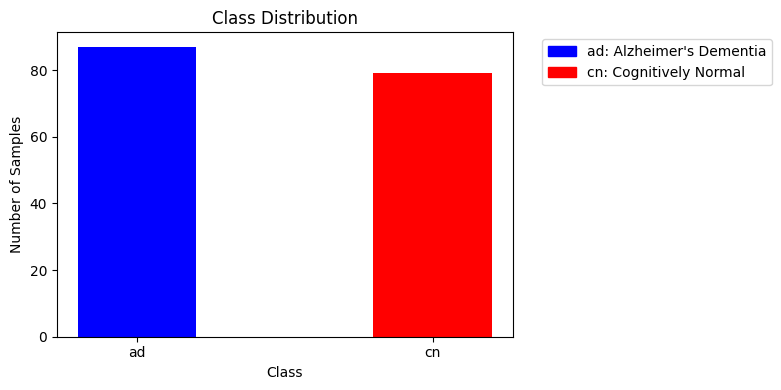

In [ ]:
# count files in each audio directory
ad_count = count_files(str(paths['audio_ad']))
cn_count = count_files(str(paths['audio_cn']))

print(ad_count)
print(cn_count)

# prepare data for plotting
classes = ['ad', 'cn']
counts = [ad_count, cn_count]
colors = ['blue', 'red']

# create bar chart
plt.figure(figsize=(8, 4))
bar_width = 0.4
plt.bar(classes, counts, color=colors, width=bar_width)
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')

# create legend
legend_handles = [
    mpatches.Patch(color='blue', label="ad: Alzheimer's Dementia"),
    mpatches.Patch(color='red', label="cn: Cognitively Normal")
]
plt.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


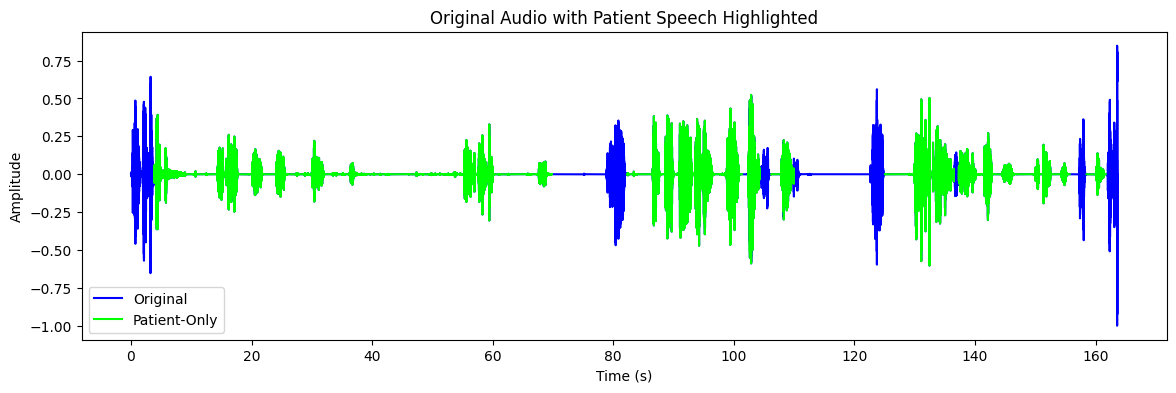

In [ ]:
# retrieve the first .wav file from the 'audio_ad' directory
first_audio_file = next(paths['audio_ad'].glob("*.wav"), None)
if first_audio_file is None:
    raise FileNotFoundError("No audio file found in the specified directory.")

# construct the corresponding segmentation CSV file path
audio_basename = first_audio_file.stem
seg_file = paths['segmentation_ad'] / f"{audio_basename}.csv"

# process the audio file with overlay plot enabled
audio, sr, patient_mask, concatenated, segments = process_audio(first_audio_file, seg_file, plot=True)


### Feature Extraction


In [ ]:
extract_full_audio_features(paths)

In [ ]:
extract_patient_audio_features(paths)

### Training

In [ ]:
perf_results, clf_models = train_and_evaluate()

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training and evaluation complete.


In [ ]:
display_results_table(perf_results, clf_models)

| Model              |   Full-Raw |   Full-Std |   Full-Noise |   Patient-Raw |   Patient-Std |   Patient-Noise |
|--------------------|------------|------------|--------------|---------------|---------------|-----------------|
| LogisticRegression |   0.617647 |   0.735294 |     0.705882 |      0.545455 |      0.515152 |        0.515152 |
| DecisionTree       |   0.5      |   0.558824 |     0.529412 |      0.454545 |      0.515152 |        0.424242 |
| RandomForest       |   0.529412 |   0.529412 |     0.5      |      0.575758 |      0.484848 |        0.454545 |
| XGBoost            |   0.588235 |   0.588235 |     0.558824 |      0.484848 |      0.484848 |        0.393939 |
| MLP                |   0.5      |   0.470588 |     0.558824 |      0.545455 |      0.545455 |        0.575758 |


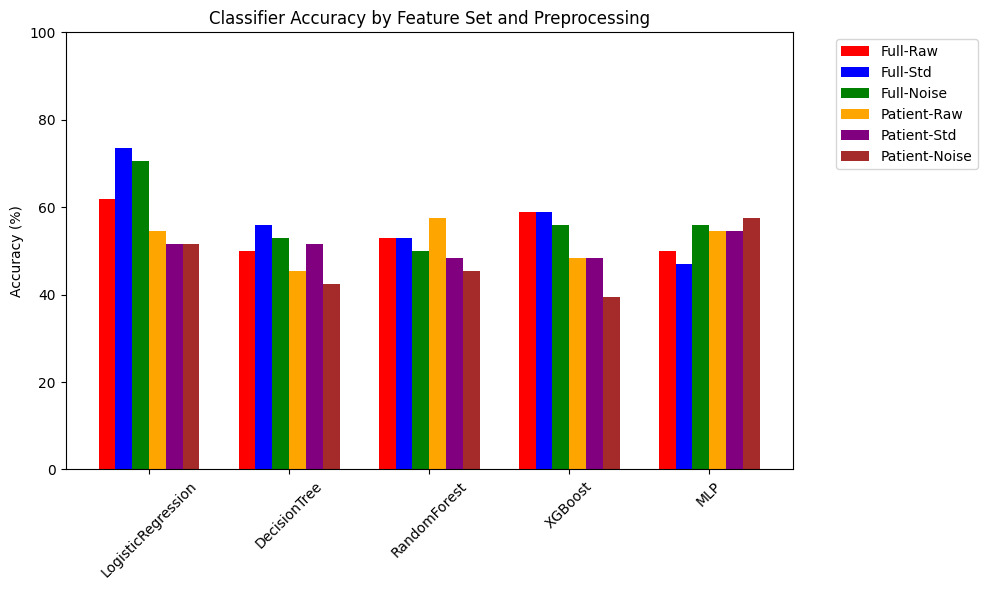

In [ ]:
plot_results(perf_results, clf_models)

### File-wise Feature Extraction

In [ ]:



def extract_segment_features(paths, min_duration_s=0.5):
    feats, labels, file_ids = [], [], []
    for audio_folder, seg_folder, label in [
        (paths['audio_ad'], paths['segmentation_ad'], 1),
        (paths['audio_cn'], paths['segmentation_cn'], 0)
    ]:
        for audio_file in audio_folder.glob("*.wav"):
            audio, sr = load_audio_file(audio_file)
            seg_df = load_segmentation(seg_folder / f"{audio_file.stem}.csv")
            _, _, segments = extract_patient_segments(audio, sr, seg_df)
            for start, end in segments:
                duration = (end - start) / sr
                if duration < min_duration_s:
                    # skip tiny segments
                    continue
                segment_audio = audio[start:end]
                vec = extract_patient_eGeMAPS(segment_audio, sr)
                feats.append(vec)
                labels.append(label)
                file_ids.append(audio_file.stem)
    return np.vstack(feats), np.array(labels), np.array(file_ids)


def compute_averaged_features(feats, labels, file_ids):
    """
    Given segment-level feats/labels/file_ids, average each file's segments
    to one vector. Returns (avg_feats, avg_labels, unique_file_ids).
    """
    avg_feats, avg_labels, unique_ids = [], [], []
    for fid in np.unique(file_ids):
        idx = file_ids == fid
        avg_feats.append(feats[idx].mean(axis=0))
        avg_labels.append(labels[idx][0])
        unique_ids.append(fid)
    return np.vstack(avg_feats), np.array(avg_labels), np.array(unique_ids)



def evaluate_averages(X, y, classifiers, test_size=0.2, random_state=42):
    """
    Split on files, then for each model build a pipeline:
      Imputer → Scaler → Classifier
    Returns accuracy on the file-level averaged features.
    """
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y,
        test_size=test_size,
        stratify=y,
        random_state=random_state
    )
    results = {}
    for name, clf in classifiers.items():
        pipe = make_pipeline(
            SimpleImputer(strategy="mean"),
            StandardScaler(),
            clone(clf)
        )
        pipe.fit(X_tr, y_tr)
        results[name] = pipe.score(X_te, y_te)
    return results


def evaluate_segments_with_majority(feats, labels, file_ids, classifiers,
                                    test_size=0.2, random_state=42):
    """
    1) Split files into train/test (so no segment leakage).
    2) Build a pipeline Imputer→Scaler→Classifier.
    3) Train on all segments from train files.
    4) Predict each segment in test files, then majority‑vote per file.
    5) Return file‑level accuracy.
    """
    # 1) file-level labels
    df_files = pd.DataFrame({'file_id': file_ids, 'label': labels})
    file_df = df_files.drop_duplicates('file_id').reset_index(drop=True)

    # 2) train/test split on file IDs
    train_ids, test_ids = train_test_split(
        file_df['file_id'],
        test_size=test_size,
        stratify=file_df['label'],
        random_state=random_state
    )

    # 3) masks for segments
    train_mask = np.isin(file_ids, train_ids)
    test_mask  = np.isin(file_ids, test_ids)

    results = {}
    for name, clf in classifiers.items():
        pipe = make_pipeline(
            SimpleImputer(strategy="mean"),
            StandardScaler(),
            clone(clf)
        )
        # train on all segments of the train files
        pipe.fit(feats[train_mask], labels[train_mask])

        # predict & vote
        file_preds = {}
        for fid in test_ids:
            idx_file    = np.where(file_ids == fid)[0]
            seg_preds   = pipe.predict(feats[idx_file])
            majority    = Counter(seg_preds).most_common(1)[0][0]
            file_preds[fid] = majority

        true = file_df.set_index('file_id').loc[test_ids, 'label']
        pred = pd.Series(file_preds)
        results[name] = (pred == true).mean()

    return results


#### Extract Everything

In [ ]:
feats_seg, labels_seg, file_ids = extract_segment_features(paths)

/usr/local/lib/python3.11/dist-packages/opensmile/core/smile.py:297: UserWarning: Segment too short, filling with NaN.
  warnings.warn(UserWarning("Segment too short, filling with NaN."))


In [ ]:
# RAW vs STD for averaged features
def evaluate_averages_variant(X, y, classifiers, standardize=False,
                              test_size=0.2, random_state=42):
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )
    results = {}
    for name, clf in classifiers.items():
        steps = [SimpleImputer(strategy="mean")]
        if standardize:
            steps.append(StandardScaler())
        steps.append(clone(clf))
        pipe = make_pipeline(*steps)
        pipe.fit(X_tr, y_tr)
        results[name] = pipe.score(X_te, y_te)
    return results

# RAW vs STD for segment+majority-vote
def evaluate_segments_variant(feats, labels, file_ids, classifiers,
                              standardize=False,
                              test_size=0.2, random_state=42):
    df_files = pd.DataFrame({'file_id': file_ids, 'label': labels})
    file_df = df_files.drop_duplicates('file_id').reset_index(drop=True)
    train_ids, test_ids = train_test_split(
        file_df['file_id'], test_size=test_size,
        stratify=file_df['label'], random_state=random_state
    )
    train_mask = np.isin(file_ids, train_ids)
    results = {}
    for name, clf in classifiers.items():
        steps = [SimpleImputer(strategy="mean")]
        if standardize:
            steps.append(StandardScaler())
        steps.append(clone(clf))
        pipe = make_pipeline(*steps)
        # train on all train segments
        pipe.fit(feats[train_mask], labels[train_mask])

        # predict + vote
        votes = {}
        for fid in test_ids:
            idx = np.where(file_ids == fid)[0]
            pred_segs = pipe.predict(feats[idx])
            votes[fid] = Counter(pred_segs).most_common(1)[0][0]

        true = file_df.set_index('file_id').loc[test_ids, 'label']
        pred = pd.Series(votes)
        results[name] = (pred == true).mean()
    return results


# compute per-file averages
feats_avg, labels_avg, file_ids_avg = compute_averaged_features(
    feats_seg, labels_seg, file_ids
)

# get classifers
classifiers = get_classifiers()

# Averaged
res_avg_raw = evaluate_averages_variant(feats_avg, labels_avg, classifiers, standardize=False)
res_avg_std = evaluate_averages_variant(feats_avg, labels_avg, classifiers, standardize=True)

# Segment+Vote
res_seg_raw = evaluate_segments_variant(feats_seg, labels_seg, file_ids, classifiers, standardize=False)
res_seg_std = evaluate_segments_variant(feats_seg, labels_seg, file_ids, classifiers, standardize=True)

# ── 4) TABULATE COMPARISON ───────────────────────────────────────────────────
from tabulate import tabulate

table = []
for model in classifiers:
    table.append([
        model,
        f"{res_avg_raw[model]:.3f}",
        f"{res_avg_std[model]:.3f}",
        f"{res_seg_raw[model]:.3f}",
        f"{res_seg_std[model]:.3f}",
    ])

print(tabulate(
    table,
    headers=["Model", "Avg‑Raw", "Avg‑Std", "Seg+Vote‑Raw", "Seg+Vote‑Std"],
    tablefmt="github"
))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

| Model              |   Avg‑Raw |   Avg‑Std |   Seg+Vote‑Raw |   Seg+Vote‑Std |
|--------------------|-----------|-----------|----------------|----------------|
| LogisticRegression |     0.636 |     0.636 |          0.667 |          0.576 |
| DecisionTree       |     0.576 |     0.545 |          0.545 |          0.576 |
| RandomForest       |     0.606 |     0.515 |          0.636 |          0.576 |
| XGBoost            |     0.576 |     0.576 |          0.667 |          0.667 |
| MLP                |     0.455 |     0.576 |          0.545 |          0.727 |


### Window-wise Feature Extraction

Each recording is partitioned into **250 ms windows with 50 % overlap**. For every window we pull the 88 eGeMAPS low-level descriptors. We then ignore the temporal order and, **for all windows belonging to the *same file*,** compute eight simple functionals—mean, std, min, max, 25 %, median, 75 %, skew—per descriptor. Concatenating these 8 × 88 numbers yields a fixed-length **704-dimensional utterance vector**, regardless of how long the conversation lasts.

We benchmark three variants  

1. **Patient-only 704** – compute the statistics using windows where the speaker tag is **PAR** (baseline).  
2. **Patient-only 704, pruned** – start from the baseline vector, then drop the lowest-informative features (e.g., bottom *x* % by ANOVA F-score) before training.  
3. **Full-dialogue 704** – compute the same statistics over **all** speech (patient + doctor) to see if clinician prompts add useful signal.

Every variant is merged with `split_master.csv` and run through the usual Random Forest, XGBoost, and MLP pipeline; accuracy, precision, recall, and F1 indicate which summarisation (and whether pruning or including doctor speech) best distinguishes AD from control.

#### 100ms windows

In [ ]:
# process with win_ms=100, overlap=0.0
all_windows_100 = batch_process(audio_paths, seg_dirs, win_ms=100, overlap=0.0, speaker="PAR")
all_windows_100.to_csv("windows_100ms.csv", index=False)
print(f"Saved {len(all_windows_100)} windows → windows_100ms.csv")

In [ ]:
compute_summary("windows_100ms.csv", "audio_100ms_feats.csv")

#### 100ms Windows with 50% overlap

In [ ]:
# process with win_ms=100, overlap=0.5
all_windows_100 = batch_process(audio_paths, seg_dirs, win_ms=100, overlap=0.5, speaker="PAR")
all_windows_100.to_csv("windows_100ms_50p.csv", index=False)
print(f"Saved {len(all_windows_100)} windows → windows_100ms_50p.csv")

In [ ]:
compute_summary("windows_100ms_50p.csv", "audio_100ms_50p_feats.csv")

#### 250ms Windows

In [ ]:
# process with win_ms=250, overlap=0.0
all_windows_100 = batch_process(audio_paths, seg_dirs, win_ms=250, overlap=0.0, speaker="PAR")
all_windows_100.to_csv("windows_250ms.csv", index=False)
print(f"Saved {len(all_windows_100)} windows → windows_250ms.csv")

In [ ]:
compute_summary("windows_250ms.csv", "audio_250ms_feats.csv")

#### 250ms windows with 50% overlap


In [5]:
# process with win_ms=100, overlap=0.0
all_windows_100 = batch_process(audio_paths, seg_dirs, win_ms=250, overlap=0.5, speaker="PAR")
all_windows_100.to_csv("windows_250ms_50p.csv", index=False)
print(f"Saved {len(all_windows_100)} windows → windows_250ms_50p.csv")

Extracting windows:  59%|█████▉    | 98/166 [21:43<10:56,  9.65s/it]

[ERROR] adrso018.wav: No 'PAR' segments in adrso018.wav
[ERROR] adrso019.wav: No 'PAR' segments in adrso019.wav
[ERROR] adrso021.wav: No 'PAR' segments in adrso021.wav
[ERROR] adrso022.wav: No 'PAR' segments in adrso022.wav
[ERROR] adrso023.wav: No 'PAR' segments in adrso023.wav


Extracting windows: 100%|██████████| 166/166 [34:56<00:00, 12.63s/it]


Saved 83945 total windows → all_windows.csv


In [13]:
compute_summary("windows_250ms_50p.csv", "audio_250ms_50p_feats.csv")

Aggregating files: 100%|██████████| 161/161 [00:13<00:00, 11.89file/s]


Final summary shape: (161, 706)
Wrote audio_250ms_50p_feats.csv


In [25]:
import re
import pandas as pd
from sklearn.preprocessing import StandardScaler

# 1) Load the 250 ms feature vectors
feats = pd.read_csv("audio_250ms_50p_feats.csv")

# 2) Load the split file
split = pd.read_csv("split_master.csv")   # has columns ["file_id","label","split"]

# 3) Merge on file_id
df = feats.merge(split, on="file_id")

# 4) Drop the n_windows column (not a feature)
df = df.drop(columns=["n_windows"])

# 5) Identify the feature columns
feat_cols = [c for c in df.columns if c not in ("file_id", "label", "split")]
print(f"Using {len(feat_cols)} features")

# 6) Zero‐fill any NaNs *before* scaling
df[feat_cols] = df[feat_cols].fillna(0)


# 8) Train & evaluate
results = train_fn(
    df,
    feat_cols,
    split_col="split",
    train_value="train",
    test_value="test",
    models=["rf", "xgb", "mlp"],
    rf_params={"n_estimators":100, "random_state":42},
    xgb_params={"n_estimators":100, "max_depth":4, "learning_rate":0.05, "random_state":42},
    mlp_params={"hidden_layer_sizes":(100,), "max_iter":300, "random_state":42}
)

# 9) Display results
format_results(results)

Using 704 features


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:36:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


+--------------+----------+-----------+--------+----------+
|    Model     | Accuracy | Precision | Recall | F1-score |
+--------------+----------+-----------+--------+----------+
| RandomForest |  0.394   |   0.444   | 0.444  |  0.444   |
|   XGBoost    |  0.576   |   0.600   | 0.667  |  0.632   |
|     MLP      |  0.394   |   0.429   | 0.333  |  0.375   |
+--------------+----------+-----------+--------+----------+


In [26]:
import re
import pandas as pd
from sklearn.preprocessing import StandardScaler

# 1) Load the 250 ms feature vectors
feats = pd.read_csv("audio_250ms_50p_feats.csv")

# 2) Load the split file
split = pd.read_csv("split_master.csv")   # has columns ["file_id","label","split"]

# 3) Merge on file_id
df = feats.merge(split, on="file_id")

# 4) Drop the n_windows column (not a feature)
df = df.drop(columns=["n_windows"])

# 5) Identify the feature columns
feat_cols = [c for c in df.columns if c not in ("file_id", "label", "split")]
print(f"Using {len(feat_cols)} features")

# 6) Zero‐fill any NaNs *before* scaling
df[feat_cols] = df[feat_cols].fillna(0)

# 7) Z‐score normalize **only** on the train split and apply to test
scaler = StandardScaler()
train_mask = df["split"] == "train"
test_mask  = df["split"] == "test"

df.loc[train_mask, feat_cols] = scaler.fit_transform(df.loc[train_mask, feat_cols])
df.loc[test_mask,  feat_cols] = scaler.transform(   df.loc[test_mask,  feat_cols])

# 8) Train & evaluate
results = train_fn(
    df,
    feat_cols,
    split_col="split",
    train_value="train",
    test_value="test",
    models=["rf", "xgb", "mlp"],
    rf_params={"n_estimators":100, "random_state":42},
    xgb_params={"n_estimators":100, "max_depth":4, "learning_rate":0.05, "random_state":42},
    mlp_params={"hidden_layer_sizes":(100,), "max_iter":300, "random_state":42}
)

# 9) Display results
format_results(results)

Using 704 features


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:36:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


+--------------+----------+-----------+--------+----------+
|    Model     | Accuracy | Precision | Recall | F1-score |
+--------------+----------+-----------+--------+----------+
| RandomForest |  0.394   |   0.444   | 0.444  |  0.444   |
|   XGBoost    |  0.576   |   0.600   | 0.667  |  0.632   |
|     MLP      |  0.485   |   0.522   | 0.667  |  0.585   |
+--------------+----------+-----------+--------+----------+


Using shap_vals of shape: (128, 704)
Selected top 352 features by SHAP importance
=== Full model on test ===
              precision    recall  f1-score   support

           0       0.33      0.27      0.30        15
           1       0.48      0.56      0.51        18

    accuracy                           0.42        33
   macro avg       0.40      0.41      0.40        33
weighted avg       0.41      0.42      0.41        33

=== Reduced model on test ===
              precision    recall  f1-score   support

           0       0.25      0.20      0.22        15
           1       0.43      0.50      0.46        18

    accuracy                           0.36        33
   macro avg       0.34      0.35      0.34        33
weighted avg       0.35      0.36      0.35        33



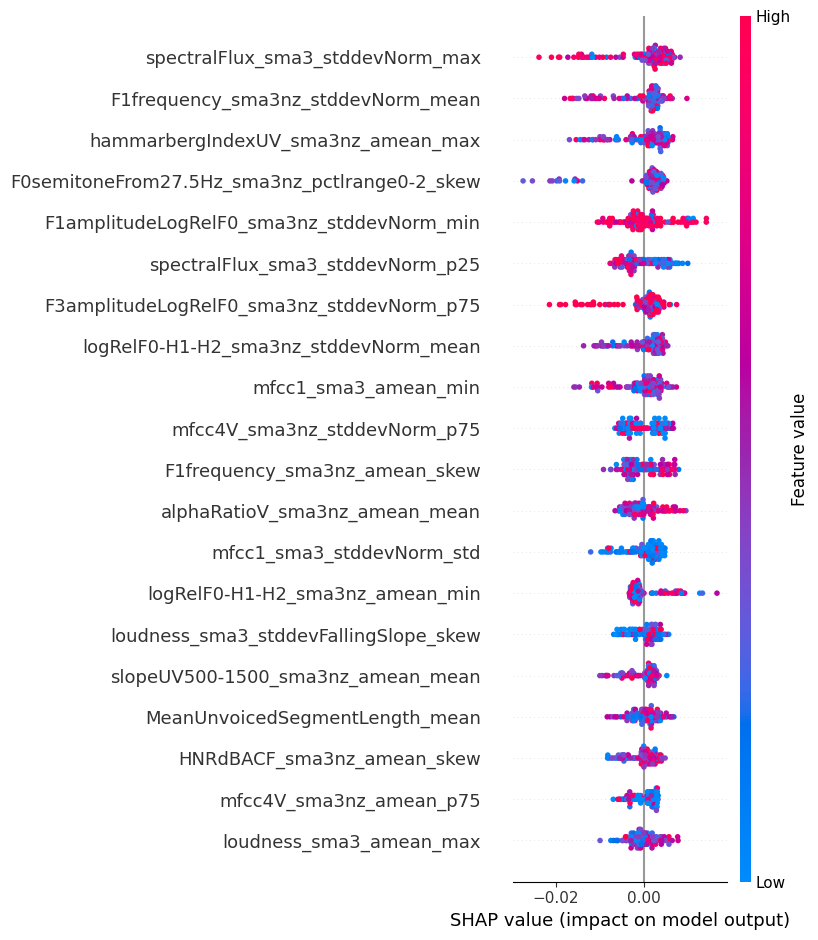

In [30]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import shap

# 1) Load & merge your data
feats = pd.read_csv("audio_250ms_50p_feats.csv")
split = pd.read_csv("split_master.csv")
df    = feats.merge(split, on="file_id").drop(columns=["n_windows"])

# 2) Identify X, y and train/test masks
feat_cols  = [c for c in df.columns if c not in ("file_id", "label", "split")]
X          = df[feat_cols].fillna(0)
y          = df["label"]
mask_train = df["split"] == "train"
mask_test  = df["split"] == "test"

# 3) First RF on all features
rf_all = RandomForestClassifier(n_estimators=200, random_state=42)
rf_all.fit(X.loc[mask_train], y.loc[mask_train])

# 4) SHAP explainer & shap values
explainer = shap.TreeExplainer(rf_all)
X_sample  = shap.sample(X.loc[mask_train], 500, random_state=42)
raw_shap  = explainer.shap_values(X_sample)

# raw_shap has shape (n_samples, n_features, n_classes)
# pick the positive-class (index 1) to get a 2D array
shap_vals = raw_shap[:, :, 1]   # shape (n_samples, n_features)
print("Using shap_vals of shape:", shap_vals.shape)

# mean absolute SHAP per feature
mean_abs_shap = np.abs(shap_vals).mean(axis=0)  # shape (n_features,)
shap_imp      = pd.Series(mean_abs_shap, index=feat_cols).sort_values(ascending=False)

# 5) Pick top 50% of features by SHAP importance
n_top     = len(shap_imp) // 2
top_feats = shap_imp.iloc[:n_top].index.tolist()
print(f"Selected top {n_top} features by SHAP importance")

# 6) Retrain RF on reduced feature set
rf_reduced = RandomForestClassifier(n_estimators=200, random_state=42)
rf_reduced.fit(X.loc[mask_train, top_feats], y.loc[mask_train])

# 7) Evaluate both on test set
print("=== Full model on test ===")
y_pred_all = rf_all.predict(X.loc[mask_test])
print(classification_report(y.loc[mask_test], y_pred_all))

print("=== Reduced model on test ===")
y_pred_red = rf_reduced.predict(X.loc[mask_test, top_feats])
print(classification_report(y.loc[mask_test], y_pred_red))

# 8) (Optional) SHAP summary plot for the top features
shap.summary_plot(shap_vals[:, :n_top], X_sample[top_feats])


### wav2vec 2.0 Embeddings

In this section we establish an audio-only baseline using **`facebook/wav2vec2-base-960h`**. Every recording is resampled to 16 kHz, fed through the model, and mean-pooled to a fixed 768-dimensional vector. We benchmark three scenarios:

1. **Full-file embeddings** – entire conversation.  
2. **Patient-only embeddings** – segments labelled **PAR** in the segmentation CSVs.  
3. **Patient-only + z-score normalisation** – same as (2) but each feature is standardised across the dataset.

Each variant is merged with `split_master.csv` and evaluated with Random Forest, XGBoost, and an MLP. Accuracy, precision, recall, and F1 let us see which representation carries the most diagnostic signal.

In [ ]:

# 1) load processor & distilled model
device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model     = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h").eval().to(device)


TARGET_SR = processor.feature_extractor.sampling_rate  # 16000

# 2) helper: resample + extract 768-D mean-pooled embedding
def extract_w2v2(audio: np.ndarray, sr: int) -> np.ndarray:
    if sr != TARGET_SR:
        audio = librosa.resample(audio, orig_sr=sr, target_sr=TARGET_SR)
        sr = TARGET_SR
    inputs = processor(audio, sampling_rate=sr,
                       return_tensors="pt", padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        hidden = model(**inputs).last_hidden_state  # (1, T, 768)
    return hidden.mean(dim=1).squeeze(0).cpu().numpy()

# 3) extract from **entire** audio files with a progress bar
BASE     = Path("ADReSSo21/diagnosis/train")
audio_ad = BASE/"audio"/"ad"
audio_cn = BASE/"audio"/"cn"

records = []
for folder, label in [(audio_ad, 1), (audio_cn, 0)]:
    wav_files = sorted(folder.glob("*.wav"))
    for wav_path in tqdm(wav_files, desc=f"Processing {folder.name}", unit="file"):
        # load full waveform at original sampling rate
        audio, sr = librosa.load(str(wav_path), sr=None)
        vec = extract_w2v2(audio, sr)
        row = {"file_id": wav_path.stem, "label": label}
        row.update({f"f{i}": float(vec[i]) for i in range(vec.shape[0])})
        records.append(row)

df_feats = pd.DataFrame(records)
df_feats.to_csv("audio_w2v2_full_feats.csv", index=False)
print("saved audio_w2v2_full_feats.csv")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Processing cn: 100%|██████████| 79/79 [00:10<00:00,  7.65file/s]


saved audio_w2v2_full_feats.csv


In [ ]:
# 1) reload the features CSV
df_feats = pd.read_csv("audio_w2v2_full_feats.csv")

# 2) reload the split file
split    = pd.read_csv("split_master.csv")  # columns: file_id | label | split

# 3) merge
df = df_feats.merge(split, on=["file_id", "label"])

# 4) select only the true feature columns (f followed by digits)
feat_cols = [c for c in df.columns if re.fullmatch(r"f\d+", c)]

print(f"Using {len(feat_cols)} feature columns")

# 5) call train_fn on RandomForest, XGBoost, and MLP
results = train_fn(
    df,
    feat_cols,
    split_col="split",
    train_value="train",
    test_value="test",
    models=["rf", "xgb", "mlp"],
    rf_params={"n_estimators":100, "random_state":42},
    xgb_params={"n_estimators":100, "max_depth":4, "learning_rate":0.05, "random_state":42},
    mlp_params={"hidden_layer_sizes":(100,), "max_iter":300, "random_state":42}
)

# 6) display the results in a pretty table
format_results(results)


Using 768 feature columns


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:28:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


+--------------+----------+-----------+--------+----------+
|    Model     | Accuracy | Precision | Recall | F1-score |
+--------------+----------+-----------+--------+----------+
| RandomForest |  0.588   |   0.611   | 0.611  |  0.611   |
|   XGBoost    |  0.647   |   0.750   | 0.500  |  0.600   |
|     MLP      |  0.588   |   0.625   | 0.556  |  0.588   |
+--------------+----------+-----------+--------+----------+


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
# 1) load model + processor
device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model     = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h") \
                         .to(device).eval()
TARGET_SR = processor.feature_extractor.sampling_rate  # 16000


# 4) iterate your dataset, extract patient-only clips & embed
BASE     = Path("ADReSSo21/diagnosis/train")
audio_ad = BASE/"audio"/"ad";    seg_ad = BASE/"segmentation"/"ad"
audio_cn = BASE/"audio"/"cn";    seg_cn = BASE/"segmentation"/"cn"

records = []
for folder, seg_folder, label in [(audio_ad, seg_ad, 1), (audio_cn, seg_cn, 0)]:
    for wav_path in tqdm(sorted(folder.glob("*.wav")), desc=f"Processing {folder.name}", unit="file"):
        # load full waveform
        audio, sr = sf.read(wav_path)
        # load segmentation
        seg_df = pd.read_csv(seg_folder / f"{wav_path.stem}.csv")
        # extract patient speech
        concat = extract_patient_segments(audio, sr, seg_df)
        if concat.size == 0:
            continue
        # get embedding (full length)
        vec = get_w2v2_embedding(concat, sr)
        # record
        row = {"file_id": wav_path.stem, "label": label}
        row.update({f"f{i}": float(vec[i]) for i in range(vec.shape[0])})
        records.append(row)

# 5) save to CSV
df = pd.DataFrame(records)
df.to_csv("audio_w2v2_patient_feats.csv", index=False)


Processing cn: 100%|██████████| 79/79 [00:13<00:00,  5.70file/s]


In [ ]:
# 1) load patient-only wav2vec2 features
df_feats = pd.read_csv("audio_w2v2_patient_feats.csv")

# 2) load canonical split
split    = pd.read_csv("split_master.csv")  # file_id | label | split

# 3) merge on file_id & label
df = df_feats.merge(split, on=["file_id", "label"])

# 4) select feature columns (f followed by digits)
feat_cols = [c for c in df.columns if re.fullmatch(r"f\d+", c)]

print(f"Using {len(feat_cols)} feature columns")

# 5) train all three models
results = train_fn(
    df,
    feat_cols,
    split_col="split",
    train_value="train",
    test_value="test",
    models=["rf", "xgb", "mlp"],
    rf_params={"n_estimators":100, "random_state":42},
    xgb_params={"n_estimators":100, "max_depth":4, "learning_rate":0.05, "random_state":42},
    mlp_params={"hidden_layer_sizes":(100,), "max_iter":300, "random_state":42}
)

# 6) display results
format_results(results)


Using 768 feature columns


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:39:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


+--------------+----------+-----------+--------+----------+
|    Model     | Accuracy | Precision | Recall | F1-score |
+--------------+----------+-----------+--------+----------+
| RandomForest |  0.606   |   0.632   | 0.667  |  0.649   |
|   XGBoost    |  0.667   |   0.684   | 0.722  |  0.703   |
|     MLP      |  0.576   |   0.611   | 0.611  |  0.611   |
+--------------+----------+-----------+--------+----------+


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
# 1) load patient-only wav2vec2 features
df_feats = pd.read_csv("audio_w2v2_patient_feats.csv")

# 2) load canonical split
split    = pd.read_csv("split_master.csv")  # file_id | label | split

# 3) merge on file_id & label
df = df_feats.merge(split, on=["file_id", "label"])

# 4) select feature columns (f followed by digits)
feat_cols = [c for c in df.columns if re.fullmatch(r"f\d+", c)]
print(f"Using {len(feat_cols)} feature columns")

# 5) normalize all feature columns (zero-mean, unit-variance)
scaler = StandardScaler()
df[feat_cols] = scaler.fit_transform(df[feat_cols])

# 6) train all three models on normalized features
results_norm = train_fn(
    df,
    feat_cols,
    split_col="split",
    train_value="train",
    test_value="test",
    models=["rf", "xgb", "mlp"],
    rf_params={"n_estimators":100, "random_state":42},
    xgb_params={"n_estimators":100, "max_depth":4, "learning_rate":0.05, "random_state":42},
    mlp_params={"hidden_layer_sizes":(100,), "max_iter":300, "random_state":42}
)

# 7) display normalized results
format_results(results_norm)

Using 768 feature columns


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:44:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


+--------------+----------+-----------+--------+----------+
|    Model     | Accuracy | Precision | Recall | F1-score |
+--------------+----------+-----------+--------+----------+
| RandomForest |  0.606   |   0.632   | 0.667  |  0.649   |
|   XGBoost    |  0.667   |   0.684   | 0.722  |  0.703   |
|     MLP      |  0.606   |   0.647   | 0.611  |  0.629   |
+--------------+----------+-----------+--------+----------+
